## Today you are a Machine Learning Engineer at the Department of Business Intelligence at Target Cosmetics!
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

This work is motivated by the publication https://arxiv.org/pdf/2010.02503.pdf and https://arxiv.org/pdf/2102.01625.pdf

This data is similar to the Ecommerce data we looked at last week, but for cosmetics retail. Also, the data indicating time-of-day, day-of-week, month, and year of the purchase have been converted to one-hot representations of these categories.

Our objective in this notebook will be to discover some structure in this data by applying some of the **unsupervised learning** methods covered in class this week.

You have access to 250,000 user-journeys and you have been asked to:
1. Find patterns among customer purchasing behaviors to identify categories of customers, i.e. how many categories of customers are there based on their purchasing behavior?
2. Visually inspect the customer categories to identify the distinctive categories and their most important features.

## Task 1: Load in data and do some feature selection

If running in Google Colab, run this first:

In [1]:
import pandas as pd

In [2]:
# this is where my copy of the data is, you should change this for your needs
df = pd.read_csv("Cosmetics_data_2019.csv")

In [3]:
df.head()

,user_id,product_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
0,537190108,27762,2,2,4749,19.03,19.03,0,1,1,...,1,0,0,0,0,0,1,0,0,0
1,577668451,5865119,1,1,0,4.60,4.60,0,1,0,...,1,0,1,0,0,0,0,0,0,0
2,607369766,5922121,1,1,0,35.71,35.71,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,572456715,5723529,1,1,0,2.94,2.94,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,566667766,5823646,1,1,0,5.22,5.22,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [4]:
df.columns

Index(['user_id', 'product_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Noon', 'Purchase'],
      dtype='object')

In [5]:
# Importing some libraries we'll use
import os
import tensorflow as tf   #<-- first time using tensorflow in this course!
from tensorboard.plugins import projector  # tensorboard for visualizing dimensionality reduction
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sb

In [6]:
YY=df.loc[:,'Purchase'].values
print(f'Percentage of interactions resulting in a purchase = {(np.sum(YY)/len(YY))*100}')

Percentage of interactions resulting in a purchase = 12.0684


This is a alot higher than we had for the electronics data! For cosmetics data, there appears to be less "window shopping," shopping around without buying. When people come to this ecommerce site they're overall more likely to make a purchase.

Create a matrix of features (AKA the "design matrix") `X` from every column in the dataframe, except for `'user_id'`, `'product_id'`, and `Purchase`. We won't be using `'user_id'` and `'product_id'` as features in this demo. The `Purchase` column is like a "label", but we're doing unsupervised learning so we won't use it in fitting the learning model. (we will use it later just to analyze how good our unsupervised learning was). Go ahead and drop `'user_id'` and `'product_id'` from the original DataFrame as well.

In [7]:
### START CODE HERE ###
df.drop(['user_id', 'product_id'], axis=1, inplace=True)
X = df.drop('Purchase', axis=1).values
### END CODE HERE ###
# Display the first few rows of the modified DataFrame
df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,InsessionCart,InsessionView,...,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
0,2,2,4749,19.03,19.03,0,1,1,1,2,...,1,0,0,0,0,0,1,0,0,0
1,1,1,0,4.60,4.60,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,1,1,0,35.71,35.71,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,0,2.94,2.94,1,0,0,13,13,...,1,0,0,0,1,0,0,0,0,0
4,1,1,0,5.22,5.22,0,1,0,0,3,...,0,0,0,0,0,1,0,0,0,0


It's good to get in the habit of encapsulating functionality you want to reuse in functions/modules outside of individual notebooks--using a separate library of functions increases the modularity of your code, eliminating the need to copy and paste this code into every notebook where you want to use it. We've provided a python file called `helper_functions_for_week3.py` that has one such function in it. Read through the function and see if you recognize it from last week!

We want to import `helper_functions_for_week3.py` but we need to make sure Python can find the file--if you're developing locally this is straightforward, but if you're using Colab you have a few options:


**Option 1**

Append the mounted Google Drive directory containing the file to the system path


**Option 2**

Upload the file directly to this virtual machine:

<img src='https://drive.google.com/uc?id=1k5OeIG_RrMQcBzyRR8LfhemdB3ZUFQCa' width="300">

**Option 3**

Use the PyDrive module, [follow the instructions here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=7taylj9wpsA2).

In [8]:
from helper_functions_for_week3 import *
#^ Importing everything from this file, if you want to add your own method of feature selection,
#  put it in helper_functions_for_week3.py and try using it below!

Now use the function we've imported (or one you wrote yourself, if you prefer) to select a subset of the features that appear informative. Create a new NumPy array `X_train` that only retains these features.

Feature ranking:
1. feature 7 (0.171403)
2. feature 0 (0.168439)
3. feature 5 (0.117723)
4. feature 6 (0.101453)
5. feature 2 (0.082864)
6. feature 1 (0.062956)
7. feature 10 (0.054205)
8. feature 8 (0.053166)
9. feature 4 (0.044448)
10. feature 3 (0.042576)
11. feature 9 (0.042194)
12. feature 18 (0.004516)
13. feature 26 (0.004165)
14. feature 16 (0.004153)
15. feature 13 (0.004037)
16. feature 15 (0.003799)
17. feature 12 (0.003794)
18. feature 14 (0.003670)
19. feature 28 (0.003655)
20. feature 17 (0.003609)
21. feature 27 (0.002778)
22. feature 31 (0.002557)
23. feature 29 (0.002411)
24. feature 32 (0.002275)
25. feature 25 (0.002271)
26. feature 30 (0.002067)
27. feature 23 (0.001911)
28. feature 21 (0.001789)
29. feature 22 (0.001690)
30. feature 24 (0.001622)
31. feature 19 (0.000926)
32. feature 20 (0.000880)
33. feature 11 (0.000000)


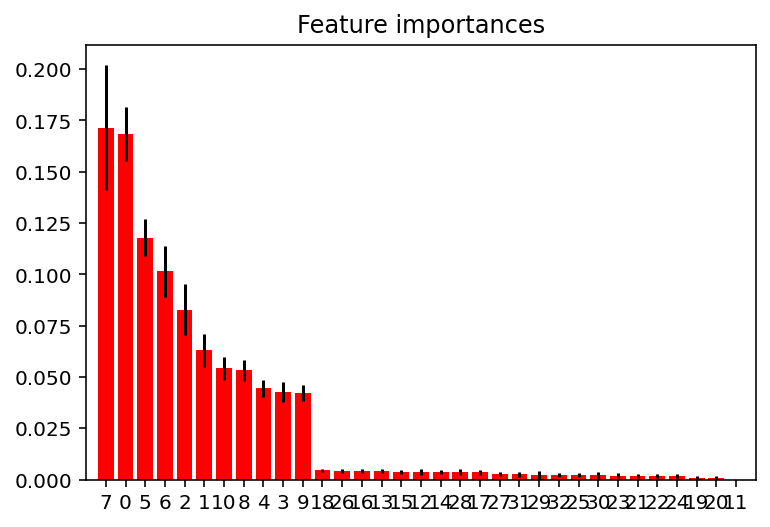

Selected Columns: ['NumRemove', 'NumOfEventsInJourney', 'NumCart', 'NumView', 'interactionTime', 'NumSessions', 'InsessionRemove', 'InsessionCart', 'minPrice', 'maxPrice', 'InsessionView']


In [9]:
### START CODE HERE ###
y_train = df['Purchase'].values
feats_rank = return_feature_rank_from_RF(X, y_train)
# Take the top 11 highest-ranked features (sharp dropoff after 11th)
df_rf_ranked = df.iloc[:, feats_rank[0][:11]]
X_train = df_rf_ranked.values
print(f'Selected Columns: {df_rf_ranked.columns.tolist()}')
### END CODE HERE ###

## Task 2: Apply dimensionality reduction and K-means clustering

We're going to do two main things in this task: 
  1. Apply dimensionality reduction to `X_train`
    * First we'll try PCA, reducing the number of features down to **5**
    * Then we'll also try t-SNE. t-SNE is a lot slower than PCA so we'll have you run t-SNE on a smaller subsample of the data, and we'll use 3 instead of 5 output features.
  2. Apply K-means clustering on the dimensionality-reduced data, using different values of "K". This is one way of assessing the quality of the dimensionality reduction. We'll summarize all this information in a single plot, the "Elbow" plot.

Use the sklearn `PCA` module you've imported above to produce `X_reduced_PCA`, a version of the data in `X_train` has been dimensionality-reduced by PCA. Use 5 PCA components, so `X_reduced_PCA` should have 5 columns.  

In [10]:
### START CODE HERE ###
pca = PCA(5)
X_reduced_PCA = pca.fit_transform(X_train)
### END CODE HERE ###
print(X_reduced_PCA.shape)

(250000, 5)


Now do dimensionality reduction with t-SNE. You can used the [TSNE module](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) in `sklearn.manifold`

Certain implementations of t-SNE can be slow, including scikit-learn's, so just fit it on the first 10000 samples of your data. Also, pick n_components=3 and perplexity=20. This can take a little while, be patient :)

Save the t-SNE-reduced version of your data as `X_reduced_tSNE`

In [11]:
from sklearn.manifold import TSNE
### START CODE HERE ###
X_reduced_tSNE = TSNE(n_components=3, perplexity=20).fit_transform(X_train[:10000])
### END CODE HERE ###
print(X_reduced_tSNE.shape)

(10000, 3)


Now we'll use the [KMeans module](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans) in sklearn.cluster, to fit Kmeans clusterings of the data. We don't know the best value of K (the number of clusters) *a priori*, so let's try all values of $k \in [1, 20]$. We can automate this with the [KElbowVisualizer module](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) of the Yellowbrick visualization library. Read the documentation of KElbowVisualizer to see how you can wrap a Kmeans model with a KElbowVisualizer, and generate an elbow plot. Generate elbow plots for both the PCA-reduced data and the t-SNE-reduced data

In [12]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

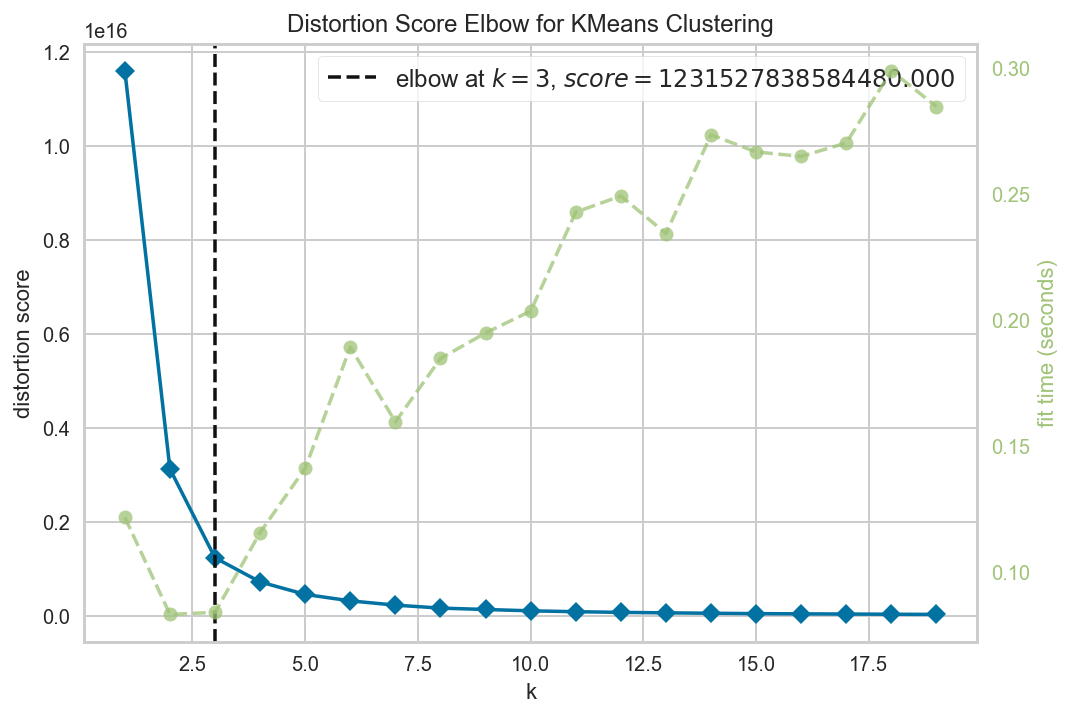

In [13]:
# fit the KElbow visualizer for the PCA-reduced data

### START CODE HERE ###
kmeans_pca = KMeans()
visualizer = KElbowVisualizer(kmeans_pca, k=(1,20))
visualizer.fit(X_reduced_PCA[:10000])
visualizer.show();
### END CODE HERE ###
# the plots may look a little different depending on whether you're doing this locally or in Colab
# If the axis labels don't display in Colab, refer to the documentation link above for an example
# figure with the axis labels

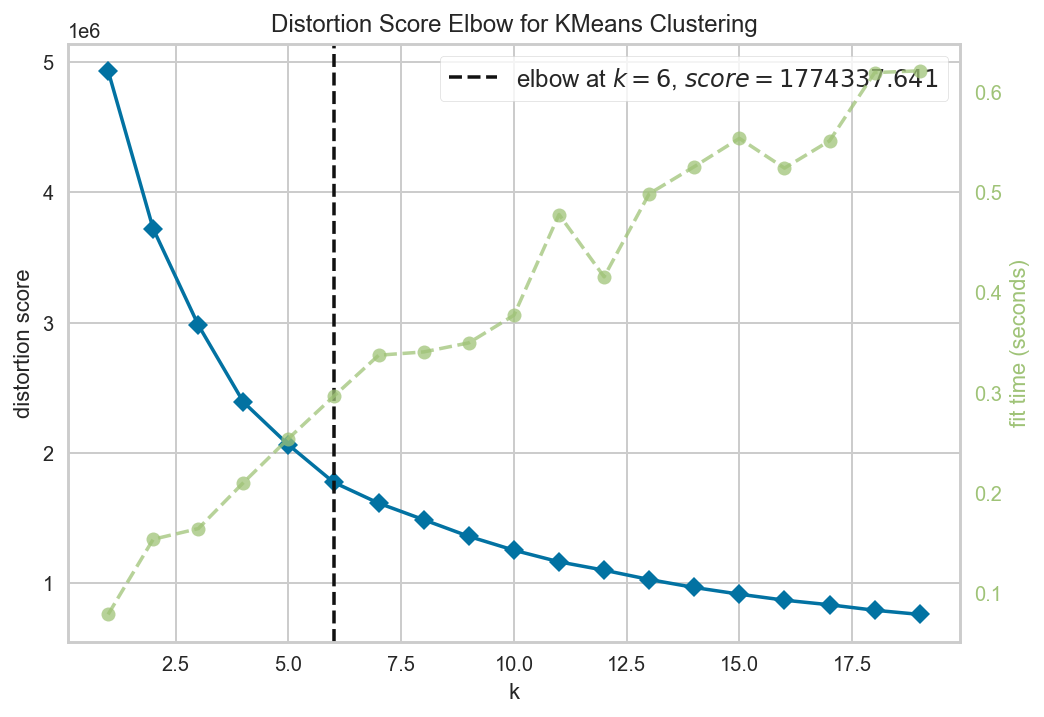

In [14]:
# do the same thing for the t-SNE-reduced data
kmeans_tsne = KMeans()
visualizer = KElbowVisualizer(kmeans_tsne, k=(1,20))
visualizer.fit(X_reduced_tSNE[:10000])
visualizer.show();
### START CODE HERE ###

### END CODE HERE ###
# the plots may look a little different depending on whether you're doing this locally or in Colab
# If the axis labels don't display in Colab, refer to the documentation link above for an example
# figure with the axis labels

Discuss with your breakout room partners what you can learn from these Elbow plots.

_The 'elbow' for the PCA-reduced data is much more pronounced than that for the tSNE-reduced data (it's questionable if the latter even has an 'elbow')._

Pick a value of K to use for clustering PCA, based on the plots you have above. Then generate an array `cluster_ids` that labels each datapoint in `X_reduced_PCA` with the cluster ID (0...K-1) that Kmeans assigns to it, when it is fit with that value of K.

In [15]:
### START CODE HERE 
# Picking k=3 (since after 3 the distortion score doesn't improve much)
kmeans_pca = KMeans(n_clusters=3)
cluster_ids = kmeans_pca.fit_predict(X_reduced_PCA)
### END CODE HERE ###
print('The unique cluster ids are ', np.unique(cluster_ids))

The unique cluster ids are  [0 1 2]


Now we create a new version of the feature-reduced data that has these cluster ids in it, and save this as a .csv file to disk:

In [16]:
# selected_columns = ['NumOfEventsInJourney', 'NumSessions', 'interactionTime', 'maxPrice',
#        'minPrice', 'NumCart', 'NumView', 'NumRemove', 'InsessionCart',
#        'InsessionView', 'InsessionRemove']
#^ these were columns I ended up selecting after the first step of Random Forest feature pruning, 
# you could change these to whatever you ended up using
selected_columns = ['NumRemove', 'NumOfEventsInJourney', 'NumCart', 'NumView',
                    'interactionTime', 'NumSessions', 'InsessionRemove', 'InsessionCart',
                    'minPrice', 'maxPrice', 'InsessionView']
temp_df = pd.DataFrame(df[selected_columns])
temp_df['Purchase'] = df['Purchase']
temp_df['ClusterID'] = cluster_ids
temp_df.head()

,NumRemove,NumOfEventsInJourney,NumCart,NumView,interactionTime,NumSessions,InsessionRemove,InsessionCart,minPrice,maxPrice,InsessionView,Purchase,ClusterID
0,1,2,0,1,4749,2,6,1,19.03,19.03,2,0,0
1,0,1,0,1,0,1,0,0,4.60,4.60,1,0,0
2,0,1,0,1,0,1,0,0,35.71,35.71,1,0,0
3,0,1,1,0,0,1,16,13,2.94,2.94,13,0,0
4,0,1,0,1,0,1,0,0,5.22,5.22,3,0,0


In [17]:
temp_df.to_csv('Clustered_data_cosmetics.csv', index=False)

## Task 3: Visualize the clusters [Instructor Led]
Tutorial on Tensorboard's embedding projector + Colab: https://colab.research.google.com/drive/1-PUVjf4eNO8QzF27lbBg6OT-yTNlBgD7

In [18]:
#Load the data with clustering labels
X_train = pd.read_csv("Clustered_data_cosmetics.csv")
X = X_train.iloc[:,0:-2].values
X_train.head()

,NumRemove,NumOfEventsInJourney,NumCart,NumView,interactionTime,NumSessions,InsessionRemove,InsessionCart,minPrice,maxPrice,InsessionView,Purchase,ClusterID
0,1,2,0,1,4749,2,6,1,19.03,19.03,2,0,0
1,0,1,0,1,0,1,0,0,4.60,4.60,1,0,0
2,0,1,0,1,0,1,0,0,35.71,35.71,1,0,0
3,0,1,1,0,0,1,16,13,2.94,2.94,13,0,0
4,0,1,0,1,0,1,0,0,5.22,5.22,3,0,0


In [19]:
pca = PCA(n_components=5)
X1 = pca.fit_transform(X)
print(X1.shape)

(250000, 5)


In [20]:
#version 1
def register_embedding(embedding_tensor_name, meta_data_fname, log_dir):
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_tensor_name
    embedding.metadata_path = meta_data_fname
    projector.visualize_embeddings(log_dir, config)

def save_labels_tsv(labels, filepath, log_dir):
    with open(os.path.join(log_dir, filepath), 'w') as f:
        for label in labels:
            f.write('{}\n'.format(label))

We need to create a directory where we can store logs for tensorboard to use

In [22]:
## Get working directory
PATH = os.getcwd()
## Path to save the embedding and checkpoints generated
os.mkdir(PATH + '/project-tensorboard/')
LOG_DIR = PATH + '/project-tensorboard/log-1'
os.mkdir(LOG_DIR)

In [23]:
META_DATA_FNAME = 'meta_cos_reduction1.tsv'  # Labels will be stored here
EMBEDDINGS_TENSOR_NAME = 'sample_data_cos_reduction1'
EMBEDDINGS_FPATH = os.path.join(LOG_DIR, EMBEDDINGS_TENSOR_NAME + '.ckpt')
STEP = 0

register_embedding(EMBEDDINGS_TENSOR_NAME, META_DATA_FNAME, LOG_DIR)
save_labels_tsv(cluster_ids, META_DATA_FNAME, LOG_DIR) #version 1

In [24]:
tf.compat.v1.disable_eager_execution()
tensor_embeddings = tf.Variable(X1, name=EMBEDDINGS_TENSOR_NAME)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
saver.save(sess, EMBEDDINGS_FPATH, STEP)
sess.close()

2021-08-20 22:32:31.380591: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


If you're running this notebook locally, you can start tensorboard from the command line `tensorboard --logdir <path to the log directory>`. 

But to use it *embedded in a Colab notebook* you have to do the following

In [25]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

In [ ]:
%tensorboard --logdir project-tensorboard/log-1/

In [ ]:
#Attach an image of the optimal clusters and their relative position in t-SNE

### Task 4: Analysis of clusters.
Now that the records have been clustered, do the following 2 tasks:
1. Do the different clusters vary in their purchase ratio? If so by how much?
2. Plot the discriminating charecteristics of each feature to separate purchase vs not-purchase events. You could do this many ways, it's up to you. One suggestion we'll give is to use a seaborn distplot on each feature separately. You can do this one cluster at a time to see if there are any big differences between the distributions of feature values for different clusters.

In [26]:
column_values = X_train["ClusterID"].values.ravel()
unique_cluster_ids_unsorted = np.array(pd.unique(column_values))
unique_cluster_ids = np.sort(unique_cluster_ids_unsorted)

### Exercise: For each cluster, calculate the representation percentage (i.e. what percentage of the dataset's samples belong to that cluster) and purchase percentage (i.e. what percentage of samples in each cluster resulted in a purchase)

In [39]:
count

Counter({0: 235527, 1: 10793, 2: 3680})

In [47]:
### START CODE HERE ###
from collections import Counter
count = Counter(column_values)
len_X = len(X_train)

pct_represent = [count[i]/len_X*100 for i in range(len(count))]
print('ClusterID:%Dataset => '
      f'0:{pct_represent[0]:.1f}%, 1:{pct_represent[1]:.1f}%, 2:{pct_represent[2]:.1f}%')

clust_purch_sum = X_train.groupby('ClusterID')['Purchase'].sum()
pct_purchase = [clust_purch_sum[i]/count[i]*100 for i in range(len(count))]
print('ClusterID:%Purchase => '
      f'0:{pct_purchase[0]:.1f}%, '
      f'1:{pct_purchase[1]:.1f}%, '
      f'2:{pct_purchase[2]:.1f}%')
### END CODE HERE ###

ClusterID:%Dataset => 0:94.2%, 1:4.3%, 2:1.5%
ClusterID:%Purchase => 0:11.5%, 1:19.2%, 2:26.1%


Then, plot the discriminating charecteristics of each feature to try and separate purchase vs not-purchase events

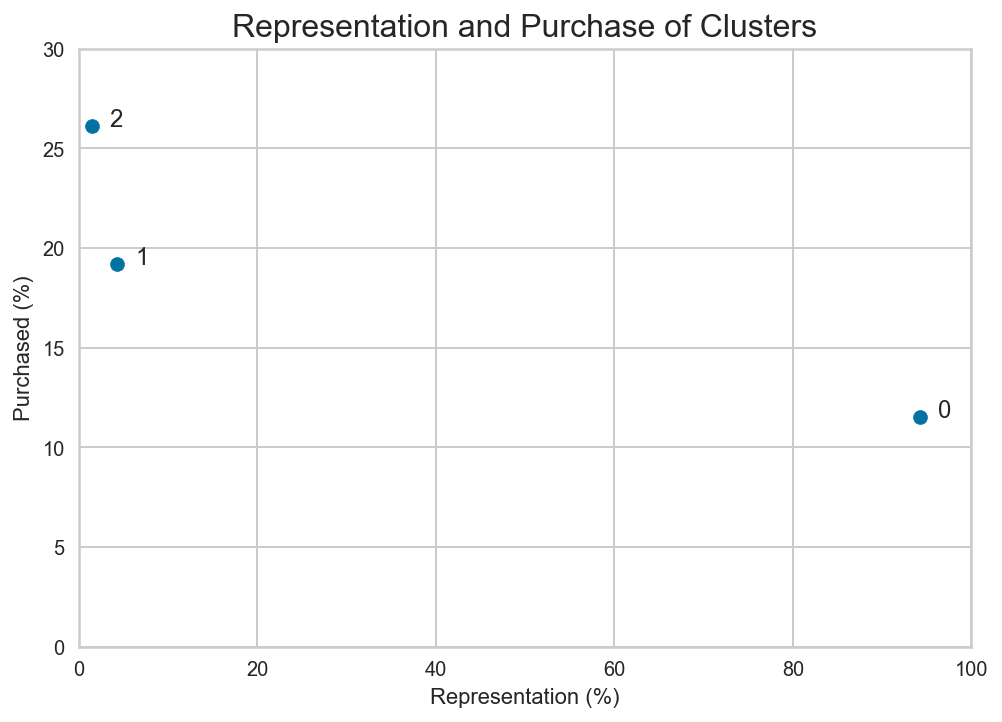

In [59]:
plt.scatter(pct_represent, pct_purchase);
plt.title('Representation and Purchase of Clusters', size=16)
plt.xlabel('Representation (%)')
plt.ylabel('Purchased (%)')
plt.xlim(0, 100)
plt.ylim(0, 30)
for i, label in enumerate(count.keys()):
    plt.annotate(label, (pct_represent[i]+2, pct_purchase[i]))

Discuss your results with your colleagues.


In [63]:
df['Purchase'].sum()/len(df)

0.120684

_Cluster0 represents the majority of the customers and has a purchasing percentage (11.5%) also close to the purchasing percentage of the dataset (12.1%). Cluster2 is the smallest cluster but has the highest purchasing rate. Cluster1 is the 2nd biggest cluster with slightly lower purchasing rate._